<a href="https://colab.research.google.com/github/sanagno/psychiatry-mri/blob/eeg/Eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from warnings import simplefilter
import autoencoder as ae
import importlib
importlib.reload(ae)
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


In [0]:
behaviour_data=pd.read_csv("HBNFinalSummaries.csv",low_memory=False)

In [0]:
behaviour_data_id=behaviour_data.EID.values

In [0]:
len(behaviour_data)

2096

In [0]:
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1
            
# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0] for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases 
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col
    
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [0]:
behaviour_data.shape

(1777, 447)

In [0]:
no_diagnosis_given = 'No Diagnosis Given'
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'No Diagnosis Given',
 'Depressive Disorders',
 'Elimination Disorders']

In [0]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [0]:
labels=behaviour_data[["EID"]+list(most_common_disorders)]

In [0]:
labels

,EID,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
0,NDARYM832PX3,1,1,0,0,0,0
1,NDARNJ687DMC,0,0,0,0,1,0
2,NDARRM363BXZ,1,0,0,0,0,0
3,NDARUW586LLL,0,0,0,0,1,0
4,NDARDC298NW4,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1772,NDARJX939UCQ,1,0,1,0,0,0
1773,NDARJJ817UP1,1,0,0,0,0,0
1774,NDARYZ986HEW,1,1,1,0,0,0
1775,NDARPM572ZZV,1,0,0,0,0,0


## EEG

In [0]:
labels[no_diagnosis_given]=labels[no_diagnosis_given].apply(lambda x:0 if x==1 else 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
most_common_disorders=[disorder for disorder in most_common_disorders if disorder!=no_diagnosis_given]

In [0]:
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'Depressive Disorders',
 'Elimination Disorders']

In [0]:
eeg_mic=pd.read_csv("RestingEEG_Microstates.csv")
eeg_psd=pd.read_csv("RestingEEG_PSD_Average.csv")
eeg_spectro=pd.read_csv("RestingEEG_Spectro_Average.csv")

len(eeg_mic),len(eeg_psd),len(eeg_spectro)


(1108, 1485, 1485)

In [0]:
eeg_mic_labels=pd.merge(eeg_mic,labels,left_on='id',right_on='EID')
eeg_psd_labels=pd.merge(eeg_psd,labels,left_on='id',right_on='EID')
eeg_spectro_labels=pd.merge(eeg_spectro,labels,left_on='id',right_on='EID')

eeg_mic_labels.drop(columns=["EID"],inplace=True)
eeg_psd_labels.drop(columns=["EID"],inplace=True)
eeg_spectro_labels.drop(columns=["EID"],inplace=True)

In [0]:
labels_id=labels.EID.values
beh_full_id=behaviour_data_id.copy()

eeg_mic_id=eeg_mic.id.values

eeg_psd_id=eeg_psd.id.values

eeg_spectro_id=eeg_spectro.id.values

sum_=0
for id in eeg_mic_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)")
    
sum_=0
for id in eeg_mic_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).")
print()

sum_=0
for id in eeg_psd_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_psd_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).")
print()

sum_=0
for id in eeg_spectro_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_spectro_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .")






There are  135 mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)
There are  158 mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).

There are  180 mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).
There are  208 mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).

There are  180 mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).
There are  208 mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .


In [0]:
print("Microstate: {:5d} Subjects\nPSD: {:12d} Subjects\nSpectro: {:8d} Subjects".\
      format(len(eeg_mic_labels),len(eeg_psd_labels),len(eeg_spectro_labels)))



Microstate:   950 Subjects
PSD:         1277 Subjects
Spectro:     1277 Subjects


In [0]:
#Sanity check for set of EEG Feautures
if(len(set(eeg_mic_id).intersection(set(eeg_psd_id),set(eeg_spectro_id)))==len(eeg_mic_id) and \
   len(set(eeg_psd_id).intersection(set(eeg_spectro_id)))==len(eeg_psd_id)):
  print("Microstate, PSD and Spectro features contain the same subjects.")


Microstate, PSD and Spectro features contain the same subjects.


## Classification


In [0]:
def binary_classifier(x,y,conf_matrix=True,classifiers=['Logistic','Random Forest','SVM'],n_splits=5,C=10):

  
  skf=StratifiedKFold(n_splits=n_splits,shuffle=True)
  
  logistic='Logistic' in classifiers
  ranfor='Random Forest' in classifiers
  suve='SVM' in classifiers

  if logistic:
    lgc=lg(C=C,class_weight='balanced')
    y_pred_lgc=np.zeros(y.shape[0])
  if ranfor:
    rfc=rf(n_estimators=100,max_depth=5,class_weight='balanced')
    y_pred_rfc=np.zeros(y.shape[0])
  if suve:
    svmc=svm(C=C,class_weight='balanced')
    y_pred_svmc=np.zeros(y.shape[0])

  for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if logistic:
          lgc.fit(x_train, y_train)
          y_pred_lgc[test_index] = lgc.predict(x_test)
        if ranfor:
          rfc.fit(x_train, y_train)
          y_pred_rfc[test_index] = rfc.predict(x_test)
        if suve:
          svmc.fit(x_train, y_train)
          y_pred_svmc[test_index] = svmc.predict(x_test)

  
  if logistic:
    print("Logistic Regression")
    print("-------------------")
    print("Accuracy :",accuracy_score(y,y_pred_lgc))
    print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_lgc))
    print("f1-score :",f1_score(y,y_pred_lgc,average='macro'))
    if conf_matrix:
      print(confusion_matrix(y,y_pred_lgc))
    print()
  
  if ranfor:
    print("Random Forest")
    print("-----------------")
    print("Accuracy :",accuracy_score(y,y_pred_rfc))
    print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_rfc))
    print("f1-score :",f1_score(y,y_pred_rfc,average='macro'))
    if conf_matrix:
      print(confusion_matrix(y,y_pred_rfc))
    print()

  if suve:
    print("SVM")
    print("----------------")
    print("Accuracy :",accuracy_score(y,y_pred_svmc))
    print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_svmc))
    print("f1-score :",f1_score(y,y_pred_svmc,average='macro'))
    if conf_matrix:
      print(confusion_matrix(y,y_pred_svmc))
    

 

### EEG_Micro


In [0]:
y_none=eeg_mic_labels[no_diagnosis_given].values==0
y=eeg_mic_labels[most_common_disorders]

In [0]:
x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x.fillna(x.mean(axis=0),inplace=True)


In [0]:
x.head()

,eyesclosed_microstates_gevtotal,eyesclosed_microstates_gfp_prototype1,eyesclosed_microstates_gfp_prototype2,eyesclosed_microstates_gfp_prototype3,eyesclosed_microstates_gfp_prototype4,eyesclosed_microstates_occurence_prototype1,eyesclosed_microstates_occurence_prototype2,eyesclosed_microstates_occurence_prototype3,eyesclosed_microstates_occurence_prototype4,eyesclosed_microstates_duration_prototype1,eyesclosed_microstates_duration_prototype2,eyesclosed_microstates_duration_prototype3,eyesclosed_microstates_duration_prototype4,eyesclosed_microstates_coverage_prototype1,eyesclosed_microstates_coverage_prototype2,eyesclosed_microstates_coverage_prototype3,eyesclosed_microstates_coverage_prototype4,eyesclosed_microstates_gev_prototype1,eyesclosed_microstates_gev_prototype2,eyesclosed_microstates_gev_prototype3,eyesclosed_microstates_gev_prototype4,eyesclosed_microstates_mspatcorr_prototype1,eyesclosed_microstates_mspatcorr_prototype2,eyesclosed_microstates_mspatcorr_prototype3,eyesclosed_microstates_mspatcorr_prototype4
0,0.815053,8.594640,7.840168,6.751696,6.155346,4.531579,3.605263,2.042105,1.826316,109.572590,74.712409,59.371134,61.798271,0.496537,0.269358,0.121242,0.112863,0.425801,0.179269,0.050128,0.033547,0.736561,0.707855,0.650813,0.648384
1,0.725810,7.300888,6.125996,5.441025,7.418961,3.929825,2.385965,0.745614,3.421053,118.696429,69.272059,58.470588,94.902564,0.466456,0.165281,0.043596,0.324667,0.305721,0.058535,0.007259,0.176843,0.702696,0.634576,0.491432,0.630921
2,0.727351,11.019322,10.683680,10.461474,10.210294,3.989474,3.515789,3.478947,2.773684,78.812665,71.227545,71.779123,66.857685,0.314421,0.250421,0.249716,0.185442,0.206668,0.148275,0.126315,0.082509,0.680067,0.669293,0.641487,0.608844
3,0.800499,6.234832,6.023094,4.939876,6.024174,3.563158,3.378947,1.710526,4.084211,74.824225,73.489097,66.381538,90.966495,0.266611,0.248316,0.113547,0.371526,0.196817,0.170259,0.045047,0.252637,0.730940,0.722275,0.659675,0.710730
4,0.770513,8.337967,7.112455,7.123003,6.603037,4.278947,2.389474,3.547368,2.057895,111.564576,62.334802,70.222552,60.531969,0.477379,0.148947,0.249105,0.124568,0.389897,0.074640,0.118653,0.044916,0.700755,0.657190,0.649427,0.616231


In [0]:

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_,classifiers='Random Forest')
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Random Forest
-----------------
Accuracy : 0.8262967430639324
Balanced Accuracy : 0.5490113636363636
f1-score : 0.5556151165907263
[[ 19 106]
 [ 38 666]]


=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Random Forest
-----------------
Accuracy : 0.5680473372781065
Balanced Accuracy : 0.5168075117370892
f1-score : 0.5147689282202557
[[ 40  85]
 [ 61 152]]


=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Random Forest
-----------------
Accuracy : 0.5126353790613718
Balanced Accuracy : 0.5076052631578948
f1-score : 0.5076041872407663
[[57 68]
 [67 85]]


=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Random Forest
-----------------
Accuracy : 0.6009389671361502
Balanced Accuracy : 0.579272

#### PCA



In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)

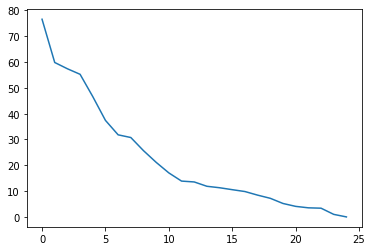

In [0]:
plt.plot(pca.singular_values_)

In [0]:
pca_x=pca.transform(x)[:,:12]

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_,classifiers=['SVM','Logistic'])
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.48612786489746684
Balanced Accuracy : 0.4770284090909091
f1-score : 0.41615085505693766
[[ 58  67]
 [359 345]]

SVM
----------------
Accuracy : 0.646562123039807
Balanced Accuracy : 0.5122727272727273
f1-score : 0.49323082379695604
[[ 40  85]
 [208 496]]

=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5059171597633136
Balanced Accuracy : 0.5253521126760563
f1-score : 0.5040025306889977
[[ 75  50]
 [117  96]]

SVM
----------------
Accuracy : 0.591715976331361
Balanced Accuracy : 0.5752488262910798
f1-score : 0.5723088208325693
[[ 64  61]
 [ 77 136]]

=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Logistic Regression
-------------------
Accuracy : 

### EEG PSD


In [0]:
y_none=eeg_psd_labels[no_diagnosis_given].values==0
y=eeg_psd_labels[most_common_disorders]

In [0]:
x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

#x.fillna(x.mean(axis=0),inplace=True) No missing values


In [0]:
x.head()

,eyesclosed_psd_01dot00hz_average,eyesclosed_psd_01dot50hz_average,eyesclosed_psd_02dot00hz_average,eyesclosed_psd_02dot50hz_average,eyesclosed_psd_03dot00hz_average,eyesclosed_psd_03dot50hz_average,eyesclosed_psd_04dot00hz_average,eyesclosed_psd_04dot50hz_average,eyesclosed_psd_05dot00hz_average,eyesclosed_psd_05dot50hz_average,eyesclosed_psd_06dot00hz_average,eyesclosed_psd_06dot50hz_average,eyesclosed_psd_07dot00hz_average,eyesclosed_psd_07dot50hz_average,eyesclosed_psd_08dot00hz_average,eyesclosed_psd_08dot50hz_average,eyesclosed_psd_09dot00hz_average,eyesclosed_psd_09dot50hz_average,eyesclosed_psd_10dot00hz_average,eyesclosed_psd_10dot50hz_average,eyesclosed_psd_11dot00hz_average,eyesclosed_psd_11dot50hz_average,eyesclosed_psd_12dot00hz_average,eyesclosed_psd_12dot50hz_average,eyesclosed_psd_13dot00hz_average,eyesclosed_psd_13dot50hz_average,eyesclosed_psd_14dot00hz_average,eyesclosed_psd_14dot50hz_average,eyesclosed_psd_15dot00hz_average,eyesclosed_psd_15dot50hz_average,eyesclosed_psd_16dot00hz_average,eyesclosed_psd_16dot50hz_average,eyesclosed_psd_17dot00hz_average,eyesclosed_psd_17dot50hz_average,eyesclosed_psd_18dot00hz_average,eyesclosed_psd_18dot50hz_average,eyesclosed_psd_19dot00hz_average,eyesclosed_psd_19dot50hz_average,eyesclosed_psd_20dot00hz_average,eyesclosed_psd_20dot50hz_average,...,eyesopen_psd_70dot50hz_average,eyesopen_psd_71dot00hz_average,eyesopen_psd_71dot50hz_average,eyesopen_psd_72dot00hz_average,eyesopen_psd_72dot50hz_average,eyesopen_psd_73dot00hz_average,eyesopen_psd_73dot50hz_average,eyesopen_psd_74dot00hz_average,eyesopen_psd_74dot50hz_average,eyesopen_psd_75dot00hz_average,eyesopen_psd_75dot50hz_average,eyesopen_psd_76dot00hz_average,eyesopen_psd_76dot50hz_average,eyesopen_psd_77dot00hz_average,eyesopen_psd_77dot50hz_average,eyesopen_psd_78dot00hz_average,eyesopen_psd_78dot50hz_average,eyesopen_psd_79dot00hz_average,eyesopen_psd_79dot50hz_average,eyesopen_psd_80dot00hz_average,eyesopen_psd_80dot50hz_average,eyesopen_psd_81dot00hz_average,eyesopen_psd_81dot50hz_average,eyesopen_psd_82dot00hz_average,eyesopen_psd_82dot50hz_average,eyesopen_psd_83dot00hz_average,eyesopen_psd_83dot50hz_average,eyesopen_psd_84dot00hz_average,eyesopen_psd_84dot50hz_average,eyesopen_psd_85dot00hz_average,eyesopen_psd_85dot50hz_average,eyesopen_psd_86dot00hz_average,eyesopen_psd_86dot50hz_average,eyesopen_psd_87dot00hz_average,eyesopen_psd_87dot50hz_average,eyesopen_psd_88dot00hz_average,eyesopen_psd_88dot50hz_average,eyesopen_psd_89dot00hz_average,eyesopen_psd_89dot50hz_average,eyesopen_psd_90dot00hz_average
0,13.252075,13.171060,10.303562,7.247638,5.177531,4.012201,3.257799,2.716654,2.334777,2.064073,1.951010,2.106707,2.599794,3.398925,5.155590,8.938139,12.533943,11.535839,6.956389,3.230759,1.504203,0.841712,0.597280,0.486366,0.416022,0.391247,0.391266,0.386449,0.366163,0.334611,0.294511,0.267583,0.273096,0.293408,0.299024,0.292122,0.284493,0.257461,0.204511,0.160624,...,0.041974,0.041617,0.038385,0.034233,0.032711,0.033877,0.034532,0.033885,0.033288,0.033455,0.033305,0.032292,0.031645,0.033093,0.035101,0.034616,0.033599,0.034358,0.034409,0.032573,0.030488,0.029183,0.029474,0.031485,0.032308,0.030559,0.028891,0.028484,0.028546,0.028926,0.030418,0.032051,0.030983,0.028301,0.028747,0.031572,0.032276,0.031815,0.030898,0.024803
1,18.933153,16.288860,10.595218,6.793446,5.170341,4.259245,3.492614,2.900088,2.419868,2.061413,1.849428,1.643705,1.433840,1.284499,1.148665,0.957932,0.774339,0.713294,0.722093,0.685296,0.611052,0.538792,0.473819,0.421145,0.378297,0.333074,0.284930,0.253142,0.256997,0.264753,0.252979,0.235653,0.220426,0.207347,0.197353,0.196580,0.201940,0.198415,0.186404,0.174339,...,0.017367,0.017632,0.018009,0.017191,0.016044,0.015546,0.015629,0.016328,0.017420,0.018440,0.019046,0.019026,0.018132,0.017376,0.016868,0.016151,0.016245,0.018334,0.020296,0.019596,0.017474,0.015387,0.014524,0.015458,0.017637,0.018725,0.017394,0.015399,0.013978,0.013282,0.013946,0.014787,0.014436,0.013733,0.013491,0.013280,0.012857,0.

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5832583258325833
Balanced Accuracy : 0.5456140350877192
f1-score : 0.4876160574387825
[[ 84  87]
 [376 564]]

Random Forest
-----------------
Accuracy : 0.7776777677767777
Balanced Accuracy : 0.5409045663804902
f1-score : 0.5431751025877927
[[ 34 137]
 [110 830]]

SVM
----------------
Accuracy : 0.6111611161116112
Balanced Accuracy : 0.5286145327858653
f1-score : 0.49146853146853153
[[ 70 101]
 [331 609]]

=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5360169491525424
Balanced Accuracy : 0.520030696897282
f1-score : 0.516427378496344
[[ 79  92]
 [127 174]]

Random Forest
-----------------
Accuracy : 0.5889830508474576
Balanced Accuracy : 0.5438790775388083
f1-score : 0.5441656710473914
[[ 65 106]
 [

#### PCA


In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


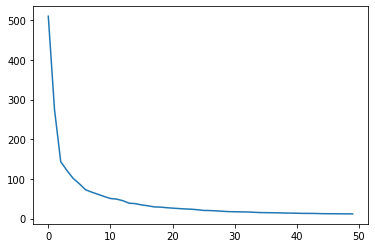

In [0]:
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:10]

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_,classifiers=['SVM','Logistic'])
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5454545454545454
Balanced Accuracy : 0.5280577329849446
f1-score : 0.46360059849038926
[[ 86  85]
 [420 520]]

SVM
----------------
Accuracy : 0.8037803780378038
Balanced Accuracy : 0.49892061714570113
f1-score : 0.4870772905936568
[[ 10 161]
 [ 57 883]]

=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.565677966101695
Balanced Accuracy : 0.5496007460511745
f1-score : 0.5456914401618909
[[ 84  87]
 [118 183]]

SVM
----------------
Accuracy : 0.5720338983050848
Balanced Accuracy : 0.48260185347088647
f1-score : 0.4586664244186046
[[ 27 144]
 [ 58 243]]

=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Logistic Regression
-------------------
Accuracy 

### EEG SPECTRO


In [0]:
y_none=eeg_spectro_labels[no_diagnosis_given].values==0
y=eeg_spectro_labels[most_common_disorders]

In [0]:
x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

In [0]:
x.shape

(1277, 60)

In [0]:
# proportion of missing values per column with missing values
missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

eyesclosed_alphapeak_max_freq :  0.16836335160532498
eyesclosed_alphapeak_max_amplitude :  0.16836335160532498
eyesclosed_alphapeak_derivative_freq :  0.1581832419733751
eyesclosed_alphapeak_derivative_amplitude :  0.1581832419733751
eyesclosed_fooof_peak_freq_average :  0.0031323414252153485
eyesclosed_fooof_peak_amplitude_average :  0.0031323414252153485
eyesopen_alphapeak_max_freq :  0.33046202036021927
eyesopen_alphapeak_max_amplitude :  0.33046202036021927
eyesopen_alphapeak_derivative_freq :  0.2725137039937353
eyesopen_alphapeak_derivative_amplitude :  0.2725137039937353
eyesopen_fooof_peak_freq_average :  0.004698512137823023
eyesopen_fooof_peak_amplitude_average :  0.004698512137823023


In [0]:
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()


=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5643564356435643
Balanced Accuracy : 0.5272676371780515
f1-score : 0.471833697411639
[[ 81  90]
 [394 546]]

Random Forest
-----------------
Accuracy : 0.7866786678667866
Balanced Accuracy : 0.5103427895981087
f1-score : 0.5082280431432973
[[ 19 152]
 [ 85 855]]

SVM
----------------
Accuracy : 0.7605760576057605
Balanced Accuracy : 0.5212299365434864
f1-score : 0.5218768605524061
[[ 30 141]
 [125 815]]

=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5233050847457628
Balanced Accuracy : 0.5088010724485632
f1-score : 0.5049020293422469
[[ 78  93]
 [132 169]]

Random Forest
-----------------
Accuracy : 0.6059322033898306
Balanced Accuracy : 0.5445396436828506
f1-score : 0.5422922922922924
[[ 55 116]
 [

#### PCA


In [0]:
x=(x-x.mean())/x.std()

In [0]:
pca=PCA().fit(x)

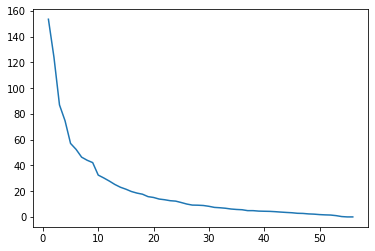

In [0]:
plt.plot(range(1,len(pca.singular_values_[:100])+1),pca.singular_values_[:100])

In [0]:
pca_x=pca.transform(x)[:,:30]

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5697569756975698
Balanced Accuracy : 0.5304591265397536
f1-score : 0.4754879108723135
[[ 81  90]
 [388 552]]

Random Forest
-----------------
Accuracy : 0.8055805580558055
Balanced Accuracy : 0.5095526937912156
f1-score : 0.5027764425069203
[[ 14 157]
 [ 59 881]]

SVM
----------------
Accuracy : 0.7155715571557155
Balanced Accuracy : 0.5185548090083365
f1-score : 0.5144821711086771
[[ 40 131]
 [185 755]]

=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Logistic Regression
-------------------
Accuracy : 0.5338983050847458
Balanced Accuracy : 0.529735190689903
f1-score : 0.521492295214923
[[ 88  83]
 [137 164]]

Random Forest
-----------------
Accuracy : 0.5889830508474576
Balanced Accuracy : 0.5110450544967069
f1-score : 0.4990371148459384
[[ 39 132]
 [ 

### All together

In [0]:
all=eeg_mic.merge(eeg_psd,how='inner',on='id')
all=all.merge(eeg_spectro,how='inner',on='id')
all_labels=all.merge(labels,how='inner',left_on='id',right_on='EID')

In [0]:
y_none=all_labels[no_diagnosis_given]==0
y=all_labels[most_common_disorders]
x=all_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

x.drop(columns=["EID"],inplace=True)


In [0]:
missing=sum(x.isnull().values)/x.shape[0]
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()



=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.6043425814234017
Balanced Accuracy : 0.5137329545454545
f1-score : 0.4803064126479313
[[ 48  77]
 [251 453]]

Random Forest
-----------------
Accuracy : 0.8021712907117008
Balanced Accuracy : 0.5446761363636363
f1-score : 0.5492175066312998
[[ 22 103]
 [ 61 643]]

SVM
----------------
Accuracy : 0.8021712907117008
Balanced Accuracy : 0.5249375000000001
f1-score : 0.5255451017616348
[[ 16 109]
 [ 55 649]]

=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5710059171597633
Balanced Accuracy : 0.5538591549295775
f1-score : 0.5512028057837238
[[ 61  64]
 [ 81 132]]

Random Forest
-----------------
Accuracy : 0.5828402366863905
Balanced Accuracy : 0.5318497652582159
f1-score : 0.5303473762010347
[[ 42  83]
 [

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression
-------------------
Accuracy : 0.5379061371841155
Balanced Accuracy : 0.540578947368421
f1-score : 0.5376108502869066
[[71 54]
 [74 78]]

Random Forest
-----------------
Accuracy : 0.5812274368231047
Balanced Accuracy : 0.5729473684210526
f1-score : 0.5727582172109349
[[ 61  64]
 [ 52 100]]

SVM
----------------
Accuracy : 0.5415162454873647
Balanced Accuracy : 0.5303684210526316
f1-score : 0.528513797863643
[[52 73]
 [54 98]]

=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.6291079812206573
Balanced Accuracy : 0.6234545454545455
f1-score : 0.6216015651352628
[[82 43]
 [36 52]]

Random Forest
-----------------
Accuracy : 0.6619718309859155
Balanced Accuracy : 0.648090909090909
f1-score : 0.6489653909540377
[[91 34]
 [38 50]]

SVM
----------------
Accuracy : 0.5070422535211268
Balanced Accuracy : 0.469
f1-score : 0.4581203207908318
[[86 39]
 [66 22]]



#### PCA

In [0]:
##PCA
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


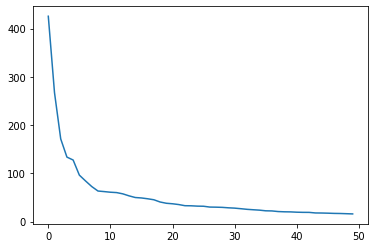

In [0]:
import matplotlib.pyplot as plt
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:20]

In [0]:

for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5705669481302774
Balanced Accuracy : 0.5464829545454546
f1-score : 0.4806130063215397
[[ 64  61]
 [295 409]]

Random Forest
-----------------
Accuracy : 0.7913148371531966
Balanced Accuracy : 0.5086761363636364
f1-score : 0.5060394501637729
[[ 13 112]
 [ 61 643]]

SVM
----------------
Accuracy : 0.8455971049457177
Balanced Accuracy : 0.4978693181818182
f1-score : 0.45816993464052286
[[  0 125]
 [  3 701]]

=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5769230769230769
Balanced Accuracy : 0.5767323943661972
f1-score : 0.5670664528900156
[[ 72  53]
 [ 90 123]]

Random Forest
-----------------
Accuracy : 0.6005917159763313
Balanced Accuracy : 0.5426291079812207
f1-score : 0.5396256873328962
[[ 40  85]
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Autoencoder

In [0]:
x=(x-x.mean()/x.std())
shape=x.shape[1]
layers=[50,25,25]
ae_=ae.Autoencoder(shape,layers=layers )
ae_.fit(x.values, print_every_epochs=1,log_path='Auto_all')


In [0]:
reconstructed_data = ae_.reconstruct(x.values,log_path='Auto_all')
loss=ae.get_reconstruction_loss(x.values,reconstructed_data)
print("Recostrunction Loss: ",loss)

INFO:tensorflow:Restoring parameters from Auto_all/model-349
Recostrunction Loss:  0.9923787504336602


In [0]:
x_encoding=ae_.encode_(x.values,log_path='Auto_all')

INFO:tensorflow:Restoring parameters from Auto_all/model-349


In [0]:
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x_encoding[y[disorder]==1],x_encoding[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  binary_classifier(x_,y_)
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5536791314837153
Balanced Accuracy : 0.5398295454545454
f1-score : 0.47024179620034545
[[ 65  60]
 [310 394]]

Random Forest
-----------------
Accuracy : 0.7599517490952955
Balanced Accuracy : 0.5560056818181818
f1-score : 0.553099730458221
[[ 33  92]
 [107 597]]

SVM
----------------
Accuracy : 0.5235223160434258
Balanced Accuracy : 0.5352329545454546
f1-score : 0.4539003543881592
[[ 69  56]
 [339 365]]

=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Logistic Regression
-------------------
Accuracy : 0.5502958579881657
Balanced Accuracy : 0.5506478873239438
f1-score : 0.5410398427729141
[[ 69  56]
 [ 96 117]]

Random Forest
-----------------
Accuracy : 0.5591715976331361
Balanced Accuracy : 0.5262910798122066
f1-score : 0.5263301449357147
[[ 50  75]
 [